In [1]:
import sys
sys.path.insert(0, '../../')  
import math
import numpy as np
import matplotlib.pyplot as plt 
from gasp import process_data_for_gasp, create_data_mask, train_gasp, run_gasp, simulate_ssfp, simulate_ssfp_sampling, SSFPParams, responses, simulation, sampling

In [2]:

def normalize(x):
    return x / np.max(x)

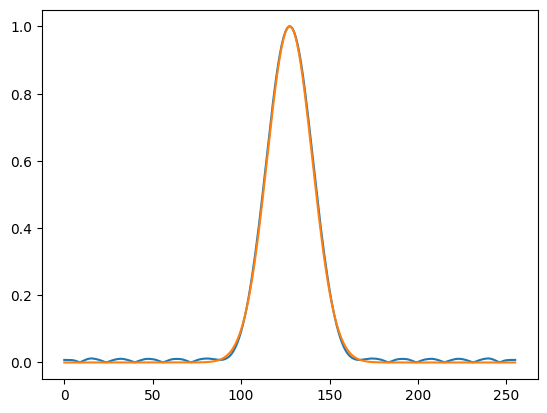

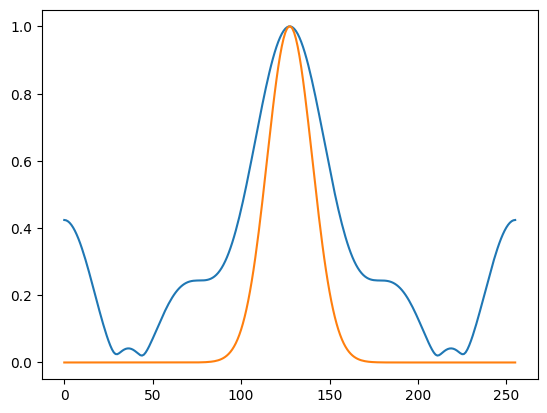

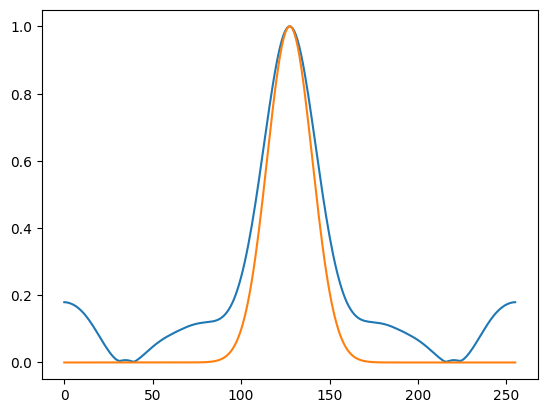

In [3]:
# Simulate ssfp with tissue phantom 
M1 = simulate_ssfp(width = 256, height = 1, npcs = 12, TRs = [3e-3, 6e-3, 12e-3], alpha = np.deg2rad(10), gradient = 2 * np.pi, phantom_type='line-muscle', phantom_padding=0)
M2 = simulate_ssfp(width = 256, height = 1, npcs = 12, TRs = [3e-3, 6e-3, 12e-3], alpha = np.deg2rad(30), gradient = 2 * np.pi, phantom_type='line-muscle', phantom_padding=0)
M3 = simulate_ssfp(width = 256, height = 1, npcs = 12, TRs = [3e-3, 6e-3, 12e-3], alpha = np.deg2rad(90), gradient = 2 * np.pi, phantom_type='line-muscle', phantom_padding=0)
D1 = responses.gaussian(width=256, bw=0.2, shift=0.-2)

# Train gasp model coefficients
method = 'affine'
Ic1, An1 = train_gasp(process_data_for_gasp(M1)[0], D1, method=method)
Ic2, An2 = train_gasp(process_data_for_gasp(M2)[0], D1, method=method)
Ic3, An3 = train_gasp(process_data_for_gasp(M3)[0], D1, method=method)

Ic4 = run_gasp(M3, An1, method=method)
Ic5 = run_gasp(M3, (An1+An2+An3)/3, method=method)

# Plot results
plt.plot(np.abs(normalize(Ic1)).T)
plt.plot(D1)
plt.show()
plt.plot(np.abs(normalize(Ic4)).T)
plt.plot(D1)
plt.show()
plt.plot(np.abs(normalize(Ic5)).T)
plt.plot(D1)
plt.show()

In [4]:
def view_gasp_comparison(G, D, ylim = 1):
    G = np.abs(G)
    length = len(G)

    f = plt.figure(figsize=(20,6))
    for i in range(length):
        ax = f.add_subplot(2, 8, i+1)
        ax2 = f.add_subplot(2, 8, 8 + i+1)

        g = G[i]
        d = D[i]
        ax.imshow(g, cmap='gray')
        ax.axis('off')
        ax2.plot(np.abs(g[int(g.shape[0]/2), :]), label='Simulated Profile')
        ax2.plot(d, '--', label='Desired Profile')
        ax2.set_ylim([0, ylim])
        if i != 0:
            ax2.yaxis.set_visible(False) 

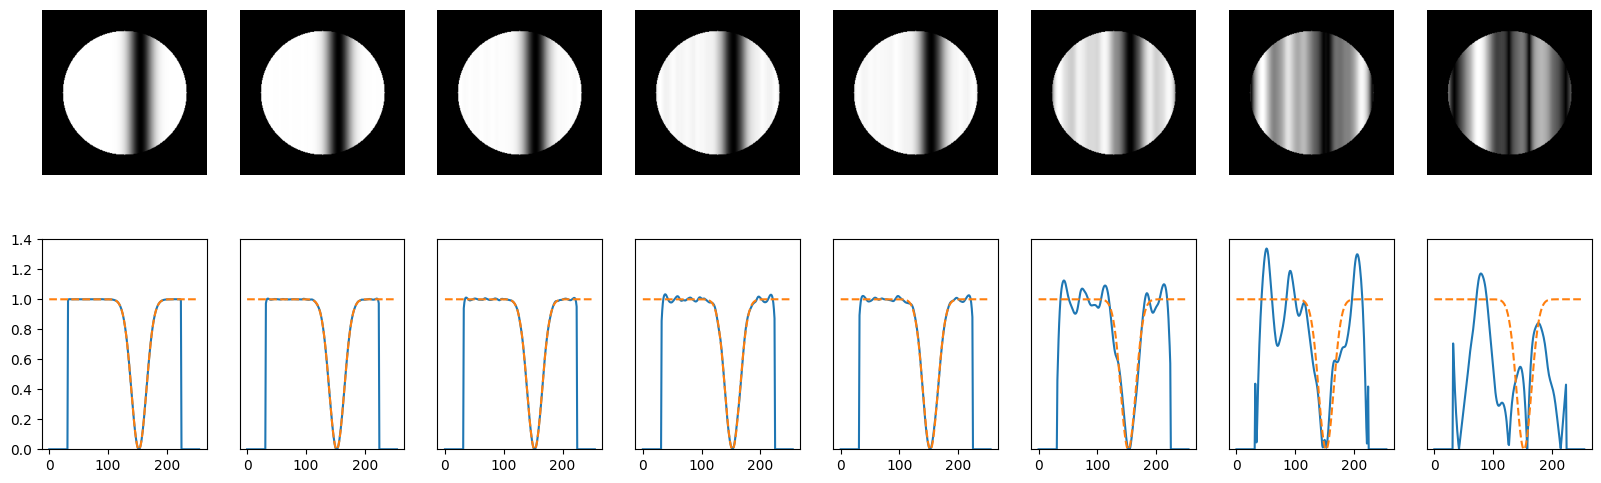

In [5]:
width = 256
height = 256
npcs = 16
alpha = np.deg2rad(60)
gradient = 2 * np.pi
phantom_type = 'circle'
D = responses.notch(width, bw=0.2, shift=0.1)

P = [{ 'npcs':16, 'TRs':[5e-3, 10e-3, 20e-3] },
     { 'npcs':14, 'TRs':[5e-3, 10e-3, 20e-3] },
     { 'npcs':12, 'TRs':[5e-3, 10e-3, 20e-3] },
     { 'npcs':10, 'TRs':[5e-3, 10e-3, 20e-3] },
     { 'npcs':8, 'TRs':[5e-3, 10e-3, 20e-3] },
     { 'npcs':6, 'TRs':[5e-3, 10e-3, 20e-3] },
     { 'npcs':4, 'TRs':[5e-3, 10e-3, 20e-3] },
     { 'npcs':2, 'TRs':[5e-3, 10e-3, 20e-3] }]

G = []
A = []
for p in P:
    M = simulation.simulate_ssfp(width=width, height=height, npcs=p['npcs'], TRs=p['TRs'], alpha = alpha, gradient = gradient, phantom_type=phantom_type)
    Ic, M, An = simulation.simulate_gasp(D, npcs=p['npcs'], TRs=p['TRs'], alpha = alpha, gradient = gradient, phantom_type=phantom_type)
    G.append(Ic)
    A.append(An)

D = [D, D, D, D, D, D, D, D]
view_gasp_comparison(G, D, ylim=1.4)

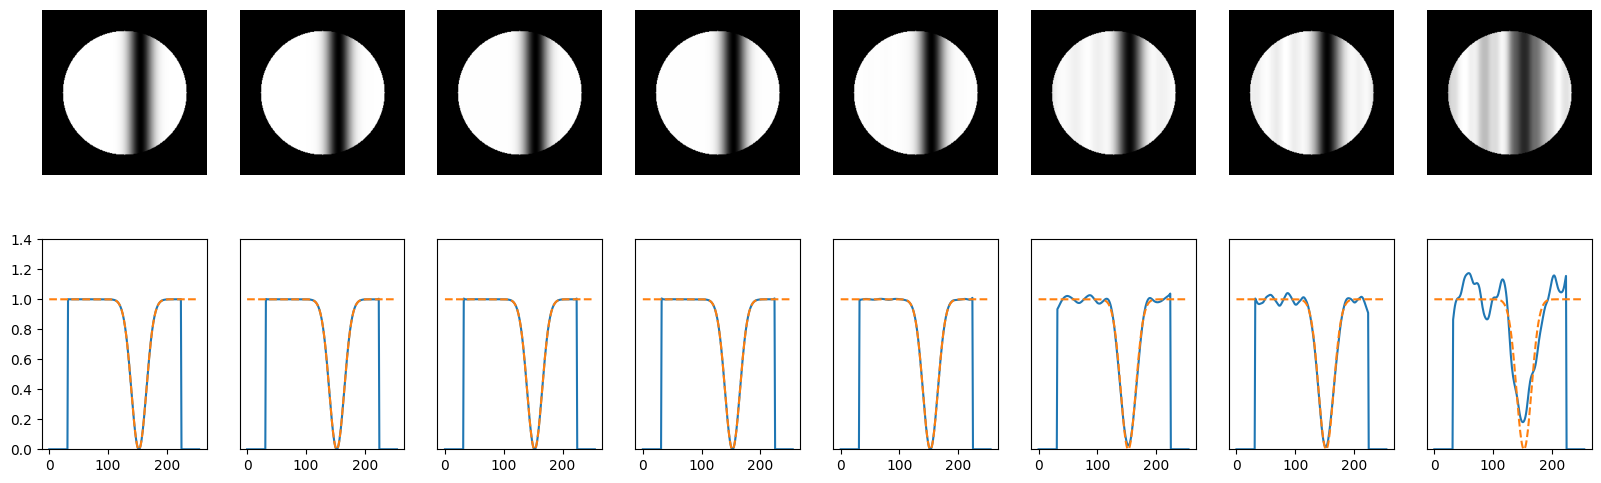

In [6]:

D = responses.notch(width, bw=0.2, shift=0.1)
P = [{ 'npcs':16, 'TRs':[5e-3, 10e-3, 20e-3] },
     { 'npcs':14, 'TRs':[5e-3, 10e-3, 20e-3] },
     { 'npcs':12, 'TRs':[5e-3, 10e-3, 20e-3] },
     { 'npcs':10, 'TRs':[5e-3, 10e-3, 20e-3] },
     { 'npcs':8, 'TRs':[5e-3, 10e-3, 20e-3] },
     { 'npcs':6, 'TRs':[5e-3, 10e-3, 20e-3] },
     { 'npcs':4, 'TRs':[5e-3, 10e-3, 20e-3] },
     { 'npcs':2, 'TRs':[5e-3, 10e-3, 20e-3] }]

M = simulation.simulate_ssfp(width=256, height=256, npcs=P[0]['npcs'], TRs=P[0]['TRs'], alpha = np.deg2rad(60), gradient = 2 * np.pi, phantom_type= 'circle')
mask = create_data_mask(M)

G = []
A = []
for p in P:
    M = simulation.simulate_ssfp(width=256, height=256, npcs=p['npcs'], TRs=p['TRs'], alpha = np.deg2rad(60), gradient = 2 * np.pi, phantom_type= 'circle')
    mask = create_data_mask(M)
    data = process_data_for_gasp(M, useMask=True)[0]
    Ic, An = train_gasp(data, D)
    G.append(Ic * mask)
    A.append(An)

D = [D, D, D, D, D, D, D, D]
view_gasp_comparison(G, D, ylim=1.4)

In [7]:
def plot_RMSE(D, sampling_schemes):
    n_points = np.linspace(6, 48, 48-6, endpoint=False).astype(np.int64) 
    RMSE = np.zeros((len(sampling_schemes), len(n_points)))
    print(RMSE.shape)
    for i, scheme in enumerate(sampling_schemes):
        print(f"scheme={scheme[0]}")
        for j, n in enumerate(n_points):
            #print(f"n={n}")
            TRs, PCs = scheme[1](n)
            params = SSFPParams(n, np.deg2rad(60), TRs, PCs)
            M = simulate_ssfp_sampling(width=256, height=1, params=params, minTR = np.min(params.TRs), gradient = 2 * np.pi, phantom_type='line')
            Ic, An = train_gasp(M, D)
            RMSE[i, j] = np.sqrt(np.mean((np.abs(Ic) - D)**2))
            #plt.plot(np.abs(Ic).T)

    plt.plot(n_points, RMSE.T)
    plt.legend(list(map(lambda x: x[0], sampling_schemes)))
    plt.show()

(4, 42)
scheme=grid_TR
6 2
7 3
8 3
9 3
10 4
11 4
12 4
13 5
14 5
15 5
16 6
17 6
18 6
19 7
20 7
21 7
22 8
23 8
24 8
25 9
26 9
27 9
28 10
29 10
30 10
31 11
32 11
33 11
34 12
35 12
36 12
37 13
38 13
39 13
40 14
41 14
42 14
43 15
44 15
45 15
46 16
47 16
scheme=gridpow-2
scheme=gridpow2-3
scheme=gridpow2-4


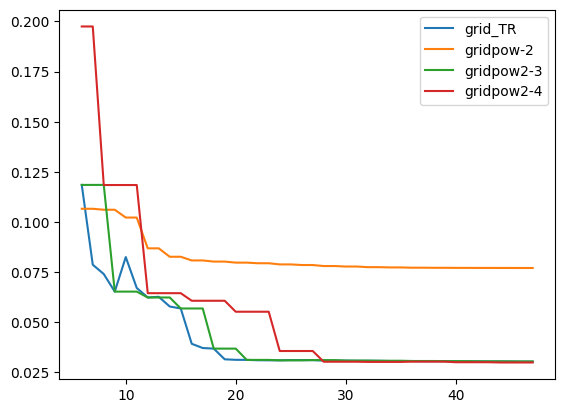

In [11]:
D = responses.notch(width, bw=0.2, shift=0.1)
tr_range = (5e-3, 20e-3)

sampling_schemes = [
    ('grid_TR', lambda n: sampling.grid_TR_sampling(n_points=n, TRs=[5e-3, 10e-3, 20e-3])),
    ('gridpow-2', lambda n: sampling.grid_pow2_sampling(n_points=n, n_turns=2, tr_range=tr_range)),
    ('gridpow2-3', lambda n: sampling.grid_pow2_sampling(n_points=n, n_turns=3, tr_range=tr_range)),
    ('gridpow2-4', lambda n: sampling.grid_pow2_sampling(n_points=n, n_turns=4, tr_range=tr_range)),
]

plot_RMSE(D, sampling_schemes)

In [9]:
np.linspace(6, 48, 48-6, endpoint=False).astype(np.int64)

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 47], dtype=int64)

In [ ]:
def SensitivityAnalysis(D, alpha0 = 10, alpha1 = 90, Nx = 90):
    width = 256
    height = 1
    npcs = 16
    TRs = [5e-3, 10e-3, 20e-3]
    gradient = 2 * np.pi
    phantom_type = 'line'

    Na = npcs * len(TRs)
    Alpha = np.linspace(alpha0, alpha1, Nx)
    Alpha = np.deg2rad(Alpha)

    # Train
    A = np.zeros((Nx, Na), dtype=np.complex128)
    for i, alpha in enumerate(Alpha):
        M = simulation.simulate_ssfp(width, height, npcs, TRs, alpha, gradient, phantom_type)
        Ic, An = simulation.train_gasp(M, D)
        An = np.array(An)
        A[i, :] = An

    # Evaluate
    MSE = np.zeros((Nx, Nx))
    for i, alpha_train in enumerate(Alpha):
        for j, alpha_data in enumerate(Alpha):
            M = simulation.simulate_ssfp(width, height, npcs, TRs, alpha_data, gradient, phantom_type)
            M = np.reshape(M, (M.shape[0], M.shape[1], -1))
            I = simulation.evaluate_gasp(M, A[i,:])
            
            yhat = np.abs(I[int(height/2), :])
            y = D
            mse = ((y - yhat)**2).mean(axis=0)  
            MSE[i,j] = mse

    return MSE

In [ ]:
def plotContour_MSE(MSE, alpha0, alpha1, Nx):
    from matplotlib import cm, ticker

    x = np.linspace(alpha0, alpha1, Nx)
    y = np.linspace(alpha0, alpha1, Nx)
    X, Y = np.meshgrid(x, y)

    fig, ax = plt.subplots()
    cs = ax.contourf(X, Y, MSE, locator=ticker.LogLocator(), cmap=cm.PuBu_r)
    cbar = fig.colorbar(cs)
    plt.show()

In [ ]:
Nx = 90
alpha0 = 10
alpha1 = 90
D = responses.gaussian(width, bw=0.2, shift=0)
MSE = SensitivityAnalysis(D, alpha0, alpha1, Nx)
plotContour_MSE(MSE, alpha0, alpha1, Nx)